# Generate multiple plots about Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and makes all
kind of plots about the data.
</i>

### Notebook configuration

In [1]:
run_number             = 4734
correction_filename    = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename           = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename_mc = f"$IC_DATA/MC/Kr/paola/corrections_MC_{run_number}.h5"
dst_filename_mc        =  "$IC_DATA/MC/Kr/paola/dst_MC.h5"
plots_output_folder    = "/Users/Gonzalo/github/papers/KrRunII/imgKr/"

XY_pitch            = 5.0

Zrange              =     0, 600
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Erange              =    35, 50
Qrange              =   200, 1500
QErange             =     0, Qrange[1] / Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =     0, 18e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  80
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          = 100
Z_fiducial          = 200

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
axis_font_size      = 40
label_font_size     = 30
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = False
plots_format        = "png"

### Imports

In [2]:
import os
import time
import collections
import itertools
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
from invisible_cities.icaro. hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels
from icaro.core.fit_functions import expo_seed

Running on  Mon Jun 18 12:02:18 2018


### Initialization

In [3]:
save_   = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None
def save(*args):
    save_(*args, bbox_inches="tight")

labels = conditional_labels(with_titles)
def labels(x, y, t="", **kwargs):
    plt.xlabel(x, **kwargs)
    plt.ylabel(y, **kwargs)
valuepm = lambda *args: measurement_string(*args).replace("+-", "\pm")

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] =    figure_size
plt.rcParams[  "font.size"            ] = axis_font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename           = os.path.expandvars(       dst_filename   )
dst_filename_mc        = os.path.expandvars(       dst_filename_mc)
correction_filename    = os.path.expandvars(correction_filename   )
correction_filename_mc = os.path.expandvars(correction_filename_mc)

In [6]:
Erange              =  35, 50
Erange              =  33.5, 49.5
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)

### Read data

In [7]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R < max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

906981


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,0,6,1.507368e+09,0,1,150.0,0.918589,5.302018,260975.0,10.7625,...,654500.0,32,393.525,393.525,110.109160,76.577461,134.119852,0.607678,13.281222,12.380607
1,1,8,1.507368e+09,0,1,125.0,1.663614,7.505072,311675.0,10.4875,...,654500.0,31,342.825,342.825,-84.927306,42.502615,94.969045,2.677578,12.633615,15.235298
2,3,12,1.507368e+09,0,1,225.0,2.741303,17.944131,209450.0,10.8625,...,653500.0,29,444.050,444.050,-34.455078,145.627975,149.648453,1.803121,12.388186,25.229376
3,5,17,1.507368e+09,0,1,200.0,1.953479,9.259772,240275.0,11.4375,...,654500.0,29,414.225,414.225,81.499882,-74.629563,110.507025,-0.741423,25.768544,12.567276
4,6,18,1.507368e+09,0,1,300.0,5.919568,32.076883,269525.0,10.6625,...,653500.0,34,383.975,383.975,15.658394,-195.197920,195.824955,-1.490750,20.252646,26.597081


In [8]:
dst_mc = dstf.load_dst(dst_filename_mc, "DST", "Events")
dst_mc = dst_mc[dst_mc.R < max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst_mc))
dst_mc.head()

3108045


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,Zrms,X,Y,R,Xrms,Yrms
0,0,1,0.0,0,1,175.0,1.631263,9.833888,100125.0,8.144594,...,427507.562500,20,327.382563,327.382563,1.658419,176.647429,-86.390831,196.641018,8.652340,9.010243
1,1,3,0.0,0,1,150.0,1.965153,9.807100,100100.0,7.154562,...,293492.218750,21,193.392219,193.392219,1.345410,-24.921252,-70.631607,74.899217,8.262545,8.445559
2,2,4,0.0,0,1,150.0,3.196390,14.845666,100125.0,9.187812,...,408475.531250,19,308.350531,308.350531,1.655377,-17.870117,177.299095,178.197391,8.521611,8.360495
3,3,5,0.0,0,1,175.0,1.354543,6.758821,100125.0,4.319953,...,146520.609375,18,46.395609,46.395609,0.803334,-74.301840,-16.062459,76.018196,7.586097,6.448224
4,4,6,0.0,0,1,150.0,1.562440,8.450720,100150.0,5.388797,...,180489.171875,20,80.339172,80.339172,0.977606,147.243927,1.019415,147.247456,8.081113,8.291674


In [9]:
ELT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

ELT_correction_mc  = dstf.load_lifetime_xy_corrections(correction_filename_mc,
                                                       group = "XYcorrections",
                                                       node  = "Lifetime")

EGEO_correction = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "index",
                                           norm_opts     = {"index": (40, 40)})

EGEO_correction_mc = dstf.load_xy_corrections(correction_filename_mc,
                                              group         =  "XYcorrections",
                                              node          = f"GeometryE_{XY_pitch:.1f}mm",
                                              norm_strategy =  "index",
                                              norm_opts     = {"index": (40, 40)})

In [10]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time .values.min()) / 60
S2e = dst.S2e.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values

E   = S2e * ELT_correction(Z, X, Y).value * EGEO_correction(X, Y).value

In [11]:
X_mc = dst_mc.X  .values
Y_mc = dst_mc.Y  .values
Z_mc = dst_mc.DT .values
R_mc = dst_mc.R  .values
E_mc = dst_mc.S2e.values * ELT_correction_mc(Z_mc, X_mc, Y_mc).value * EGEO_correction_mc(X_mc, Y_mc).value
E_mc = E_mc * 41.5 / np.mean(E_mc)

In [12]:
t, e, eu = fitf.profileX(T, E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": 41.5})

E = E * ET_correction(T).value

##### Input maps

In [13]:
import tables as tb
with tb.open_file(correction_filename) as file:
    print(file)
#    print(file.root.XYcorrections.Escale[:10])
#    print("--------")
#    print(file.root.XYcorrections.Escale[3600:3610])

/Users/Gonzalo/github/NEXTdata//XYmaps/corrections_run4734.h5 (File) ''
Last modif.: 'Wed Mar 14 02:09:51 2018'
Object Tree: 
/ (RootGroup) ''
/XYcorrections (Group) ''
/XYcorrections/Escale (Table(7200,), shuffle, zlib(4)) 'XY-dependent energy scale'
/XYcorrections/GeometryE_10.0mm (Table(1600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.0mm (Table(40000,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.2mm (Table(32400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.5mm (Table(25600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_2.9mm (Table(19600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_3.3mm (Table(14400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_4.0mm (Table(10000,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_5.0mm (Table(6400,), shuffle, zlib(4)) 'XY corrections'
/XYcorrections/GeometryE_6.7mm (Table(3600,), shuffle, zlib(4)) 'XY corrections'
/XYcorrectio

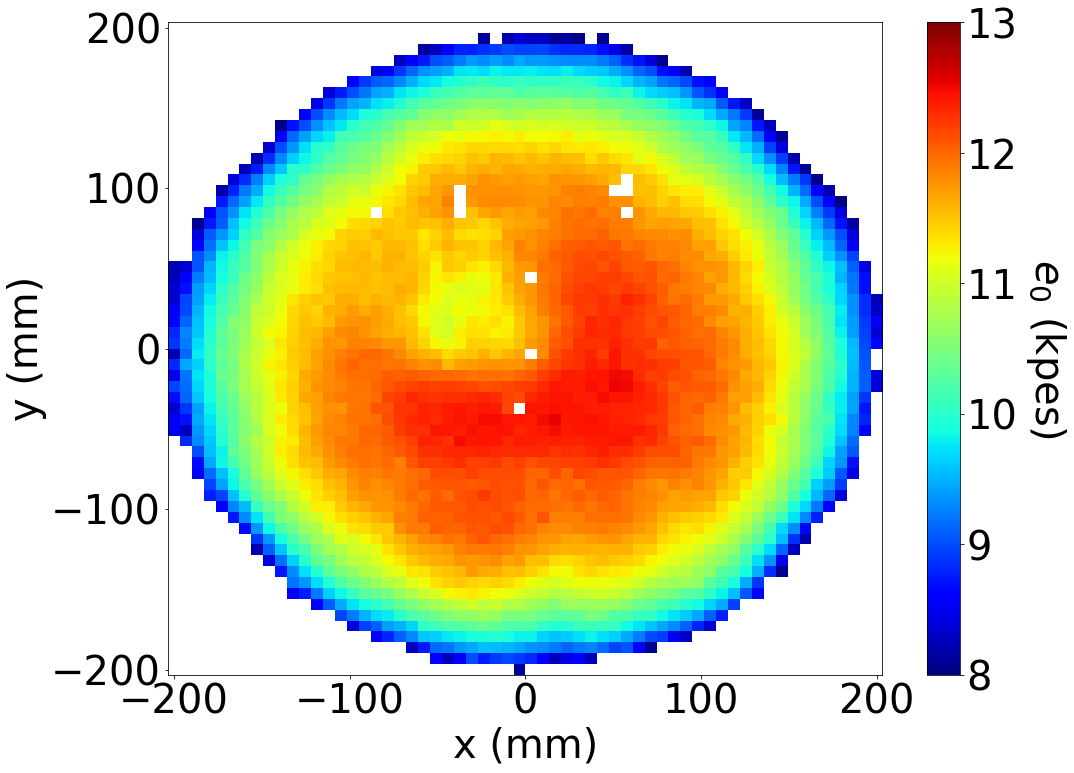

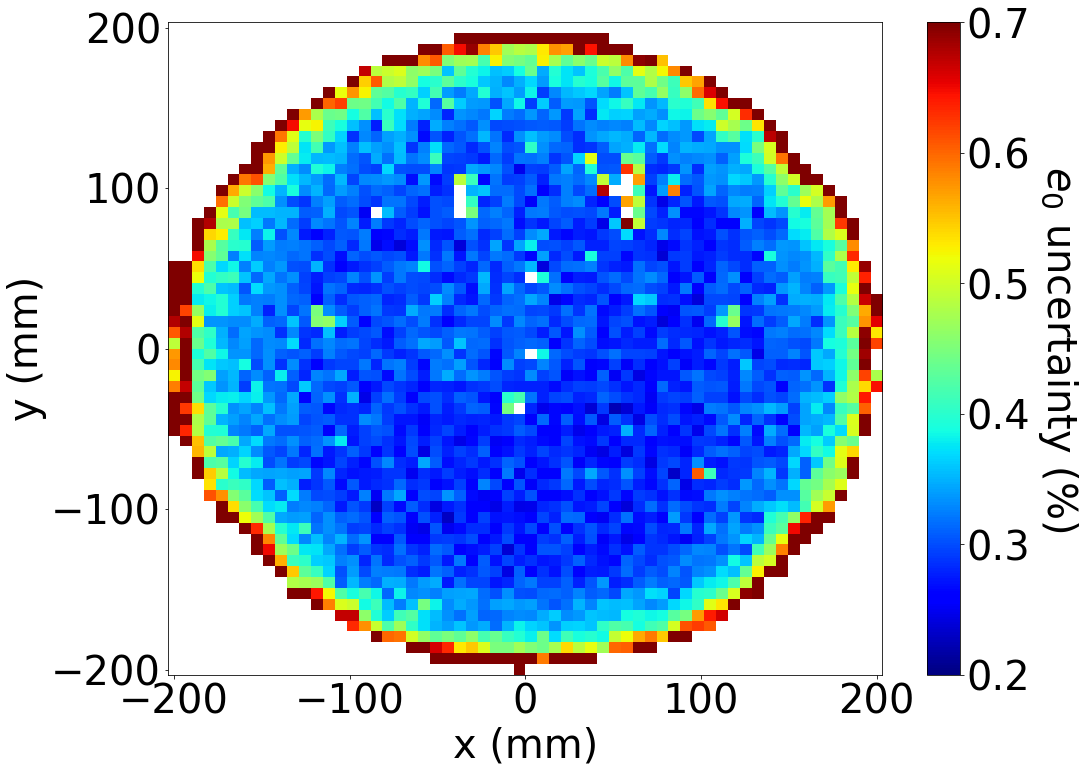

In [15]:
Emap = dstf.load_dst(correction_filename,
                     group = "XYcorrections",
                     node  = "Escale")
Emap = Emap[:3600]

x   = np.unique(Emap.x.values)
y   = np.unique(Emap.y.values)
Es  = Emap.factor     .values.reshape(x.size, y.size)
Eus = Emap.uncertainty.values.reshape(x.size, y.size)
ok  = Es != Es[0,0]

vmin =  8000/1e3
vmax = 13000/1e3

*_, cb = display_matrix(x, y, np.where(ok, Es/1e3, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)
cb.set_label("$e_0$ (kpes)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"energy_z0_map_{run_number}")

vmin = 0.2
vmax = 0.7

*_, cb = display_matrix(x, y, np.where(ok, Eus/Es*100, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)

cb.set_label("$e_0$ uncertainty (%)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"energy_z0_uncertainty_map_{run_number}")

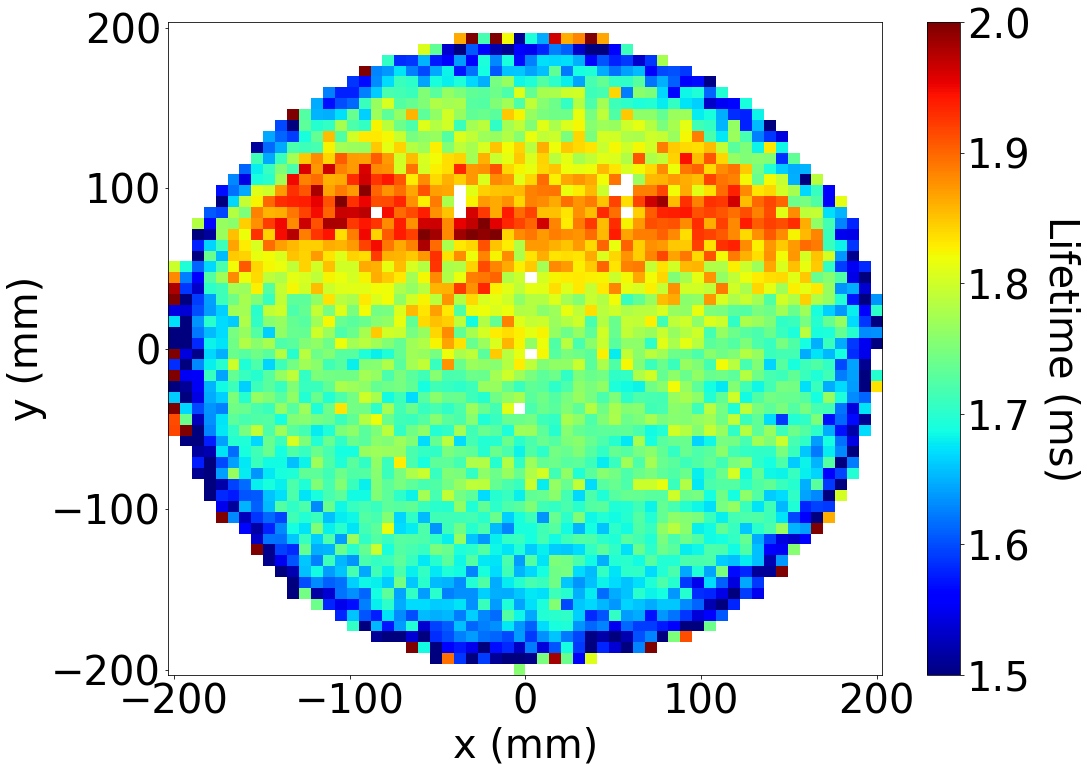

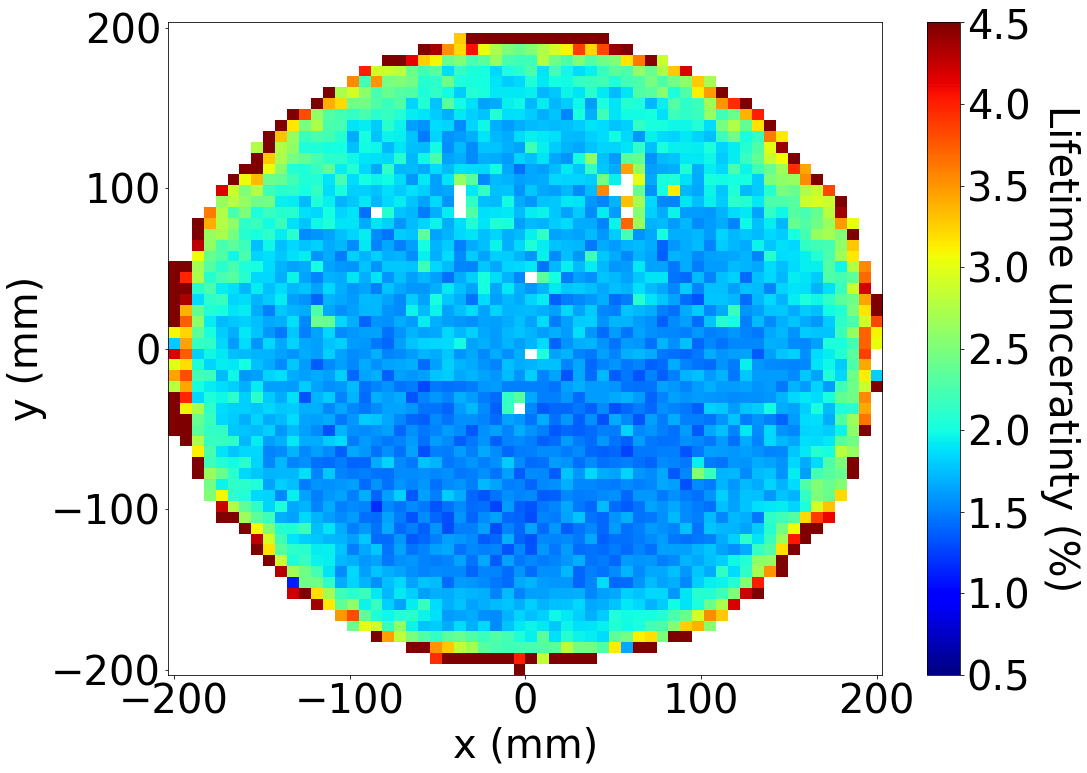

In [15]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)
ok  = LT != LT[0,0]

vmin = 1500
vmax = 2000

*_, cb = display_matrix(x, y, np.where(ok, LT / 1e3, 0),
                        vmin = vmin / 1e3,
                        vmax = vmax / 1e3,
                        cmin = 1,
                        cmap = default_cmap)

cb.set_label("Lifetime (ms)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime map")
save(f"lifetime_map_{run_number}")

vmin = 0.5
vmax = 4.5

*_, cb = display_matrix(x, y, np.where(ok, LTu/LT*100, 0),
                        vmin = vmin,
                        vmax = vmax,
                        cmin = vmin,
                        cmap = default_cmap)

cb.set_label("Lifetime unceratinty (%)", rotation=-90, labelpad=50)
labels("x (mm)", "y (mm)", "Lifetime uncertainty map")
save(f"lifetime_uncertainty_map_{run_number}")

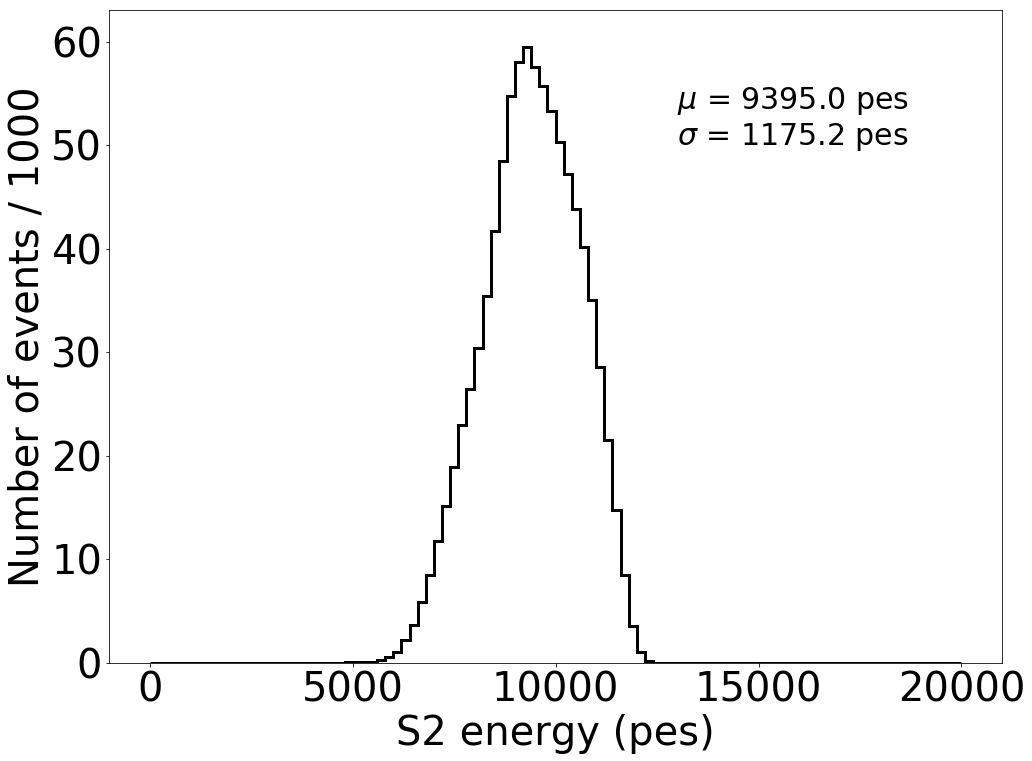

In [16]:
y, x, h = hist(S2e, 100, (0, 2e4), fill=None, ec="k", histtype='step', lw=3)
plt.xticks(np.arange(5) * 5000)

mean, std = coref.weighted_mean_and_std(x, y, unbiased=True, frequentist=True)
plt.text(13e3, 50e3, f"$\mu$ = {mean:.1f} pes\n$\sigma$ = {std:.1f} pes",
         fontsize = label_font_size)

plt.ylim(0, 63e3)
yticks = np.arange(0, 70000, 10000)
plt.yticks(yticks, list(map(lambda x: str(int(x/1000)), yticks)))
labels("S2 energy (pes)", "Number of events / 1000")

save(f"RawS2_{run_number}")

0.89865803375
1.01210590766


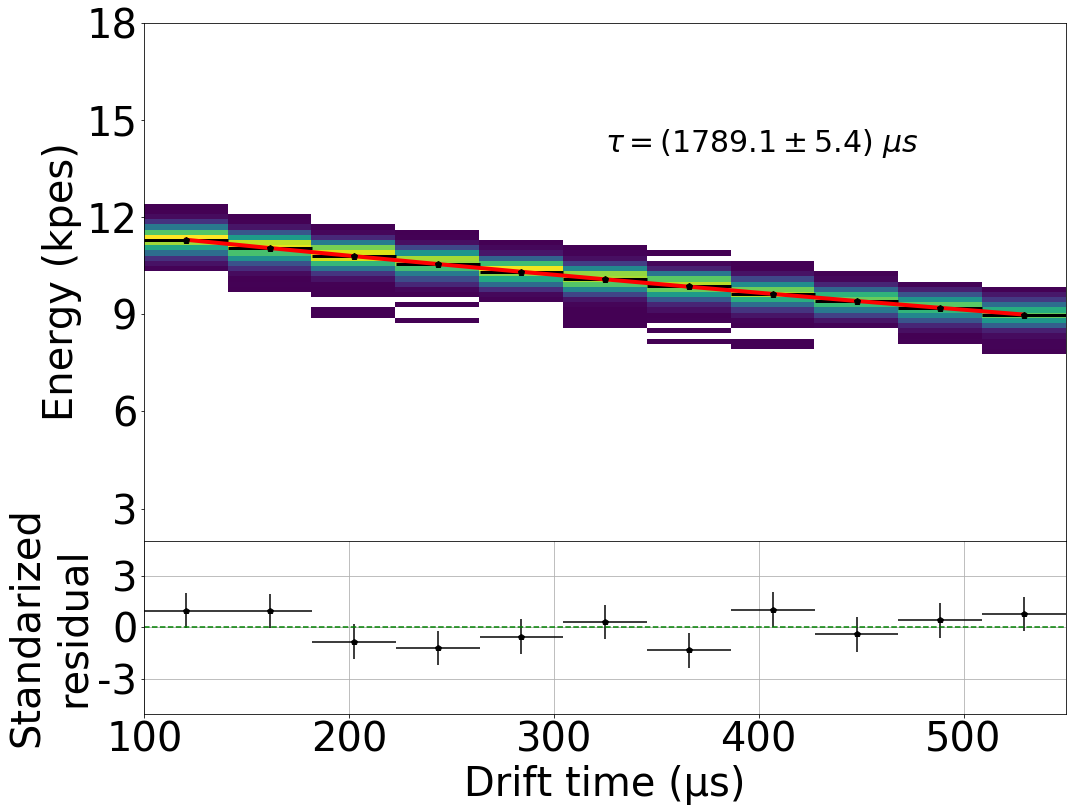

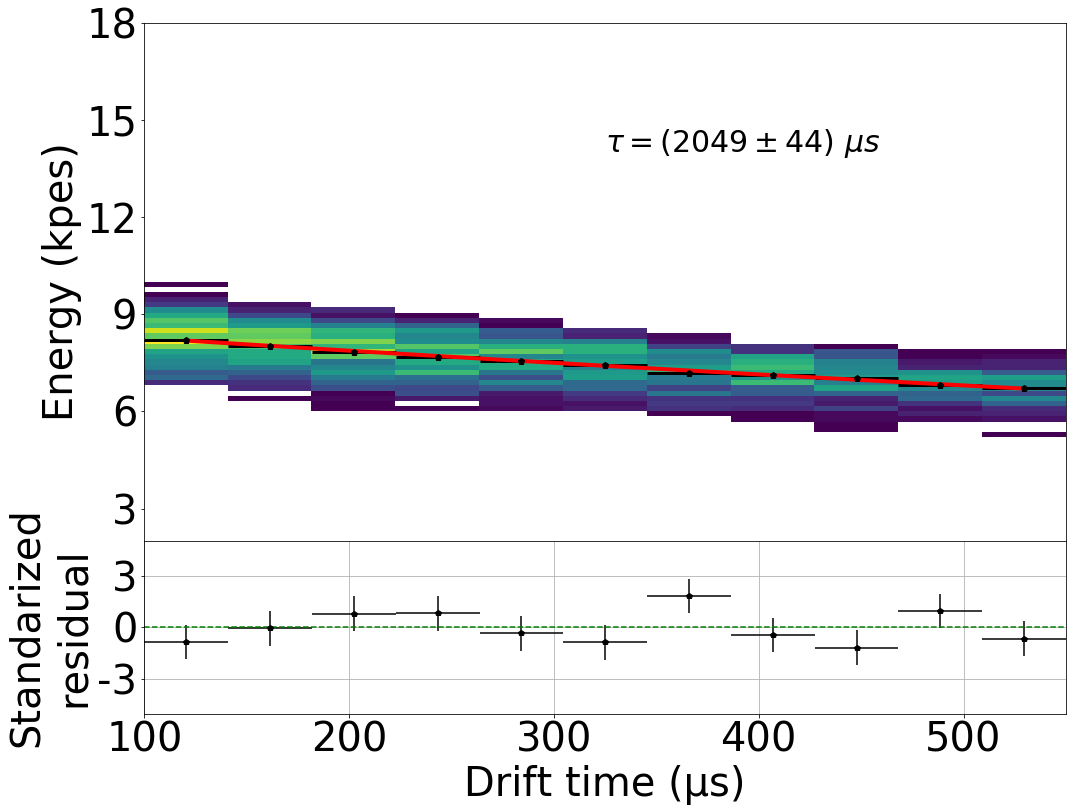

In [17]:
xylims = ((0, 50), (120, 150))
nz     =  11
ne     = 100
zrange = 100, 550
erange = 2e3, 18e3
zbins  = np.linspace(*zrange, nz + 1)
ebins  = np.linspace(*erange, ne + 1)

for lim in xylims:
    sel  = coref.in_range(X, *lim) & coref.in_range(Y, *lim)
    z, e = Z[sel], S2e[sel]

    plt.figure()
    frame_data = plt.gcf().add_axes((.1, .3,
                                     .8, .6))
    plt.hist2d(z, e, (zbins, ebins), cmin=1)

    x, y, yu = fitf.profileX(z, e, nz, zrange)
    plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

    seed = expo_seed(x, y)
    f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
    print(f.chi2)
    plt.plot(x, f.fn(x), "r-", lw=4)

    plt.text(0.5,
             0.75,
             "$\\tau = ({})\ \mu s$".format(valuepm(-f.values[1], f.errors[1])),
             transform = plt.gca().transAxes,
             fontsize = label_font_size)

    frame_data.set_xticklabels([])
    yticks = np.arange(3000, 21000, 3000)
    plt.yticks(yticks, list(map(lambda x: str(int(x/1000)), yticks)))

    labels("", "Energy (kpes)")
    lims = plt.xlim()

    frame_res = plt.gcf().add_axes((.1, .1,
                                    .8, .2))
    plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0] / 2, fmt="p", c="k")
    plt.plot(lims, (0, 0), "g--")
    plt.xlim(*lims)
    plt.ylim(-5, +5)

    yticks = np.arange(-3, 6, 3)
    plt.yticks(yticks, list(map(lambda x: str(int(x)), yticks)))

    plt.grid()
    labels("Drift time (µs)", "Standarized\nresidual")
    plt.savefig(f"lifetime_{run_number}_xy_{lim[0]}_{lim[1]}", bbox_inches='tight')
#    save(f"lifetime_{run_number}_xy_{lim[0]}_{lim[1]}")

0.942153060479
1.03416899868


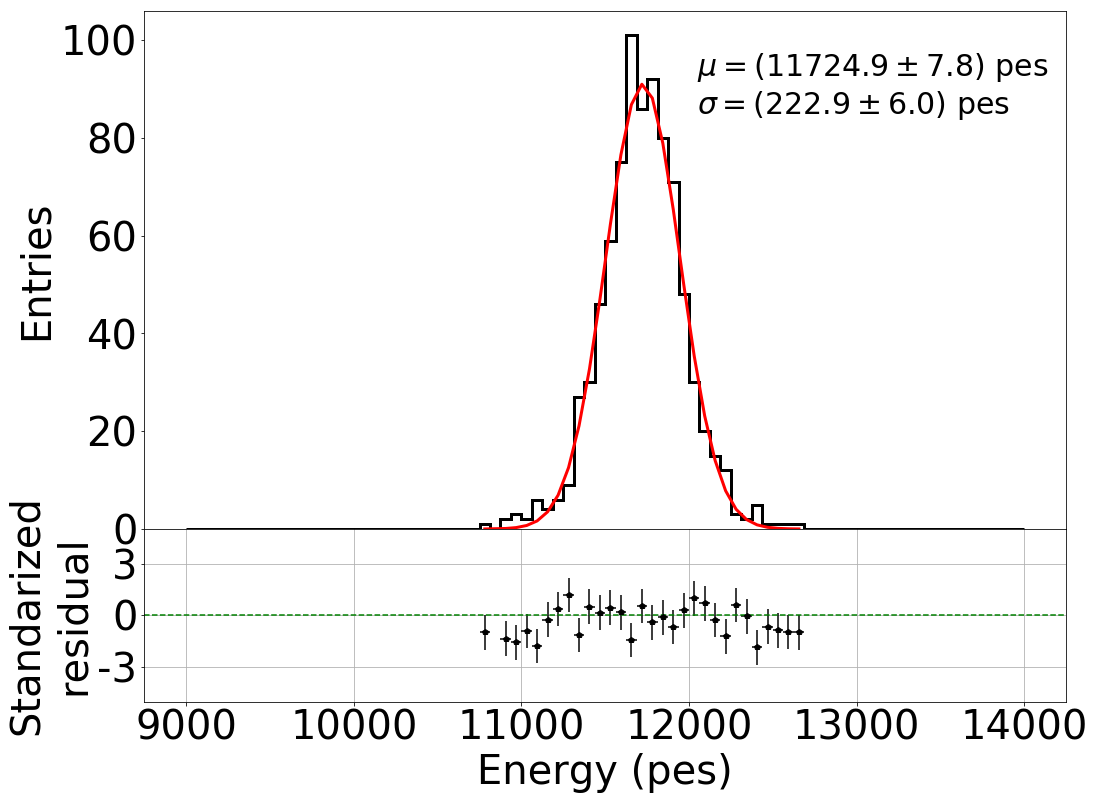

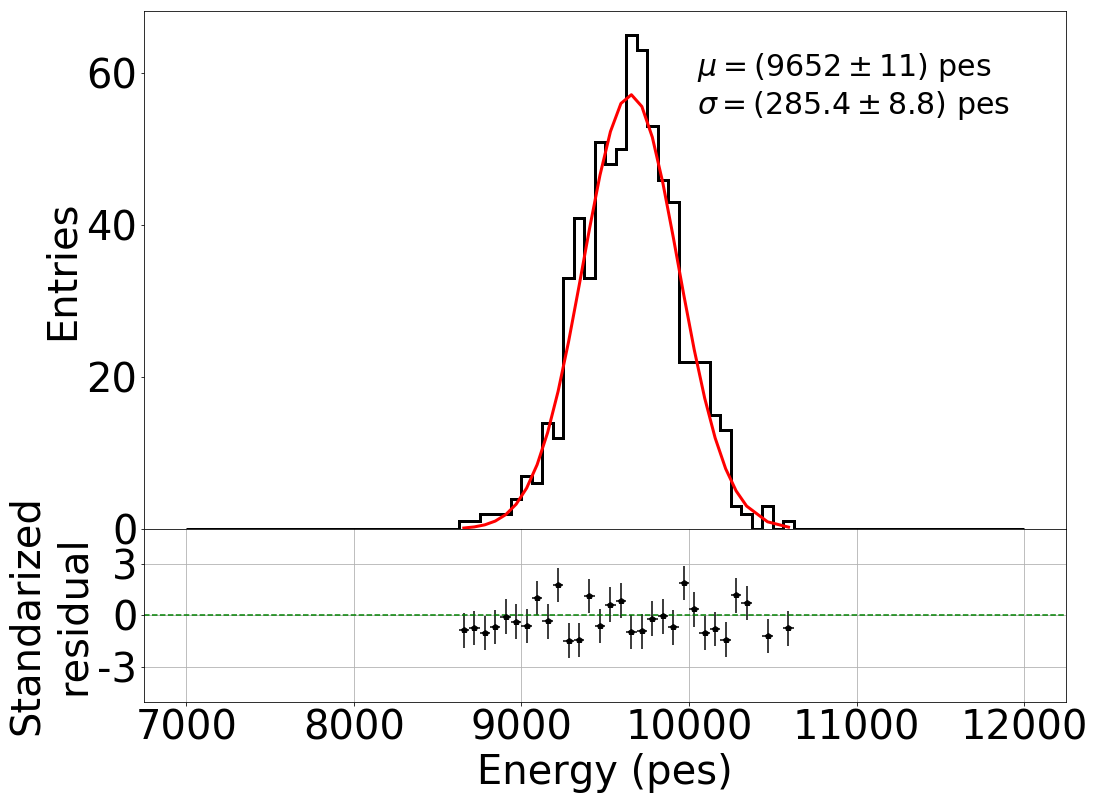

In [18]:
xylims  = ((0, 10), (120, 130))
eranges = ((9e3, 14e3), (7e3, 12e3))
ne      = 80

for lim, erange in zip(xylims, eranges):
    sel  = coref.in_range(X, *lim) & coref.in_range(Y, *lim)
    e    = S2e[sel] * ELT_correction(Z[sel], X[sel], Y[sel]).value

    ebins  = np.linspace(*erange, ne + 1)

    plt.figure()
    frame_data = plt.gcf().add_axes((.1, .3,
                                     .8, .6))
    y, x, _ = hist(e, ebins, histtype="step", ec="k", lw=3, new_figure=False)
    dx      = np.diff(x)[0] / 2
    y, x    = y[y>0], x[y>0]

    f = fitf.fit(fitf.gauss, x, y, (1, 15e3, 1e3), sigma=poisson_sigma(y))
    print(f.chi2)
    plt.plot(x, f.fn(x), "r-", lw=3)

    plt.text(0.6, 0.8,
             "$\mu = ({})$ pes\n$\sigma = ({})$ pes".format(valuepm(f.values[1], f.errors[1]),
                                                            valuepm(f.values[2], f.errors[2])),
             transform=plt.gca().transAxes,
             fontsize=30)

    lims = plt.xlim()
    frame_data.set_xticklabels([])
    labels("", "Entries")

    frame_res = plt.gcf().add_axes((.1, .1,
                                    .8, .2))
    plt.errorbar(x, (f.fn(x) - y) / poisson_sigma(y), 1, dx, fmt="p", c="k")
    plt.plot(lims, (0, 0), "g--")
    plt.xlim(*lims)
    plt.ylim(-5, +5)
    yticks = np.arange(-3, 6, 3)
    plt.yticks(yticks, list(map(lambda x: str(int(x)), yticks)))
    plt.grid()
    labels("Energy (pes)", "Standarized\nresidual")

    save(f"FitXY_{lim[0]}_{lim[1]}")

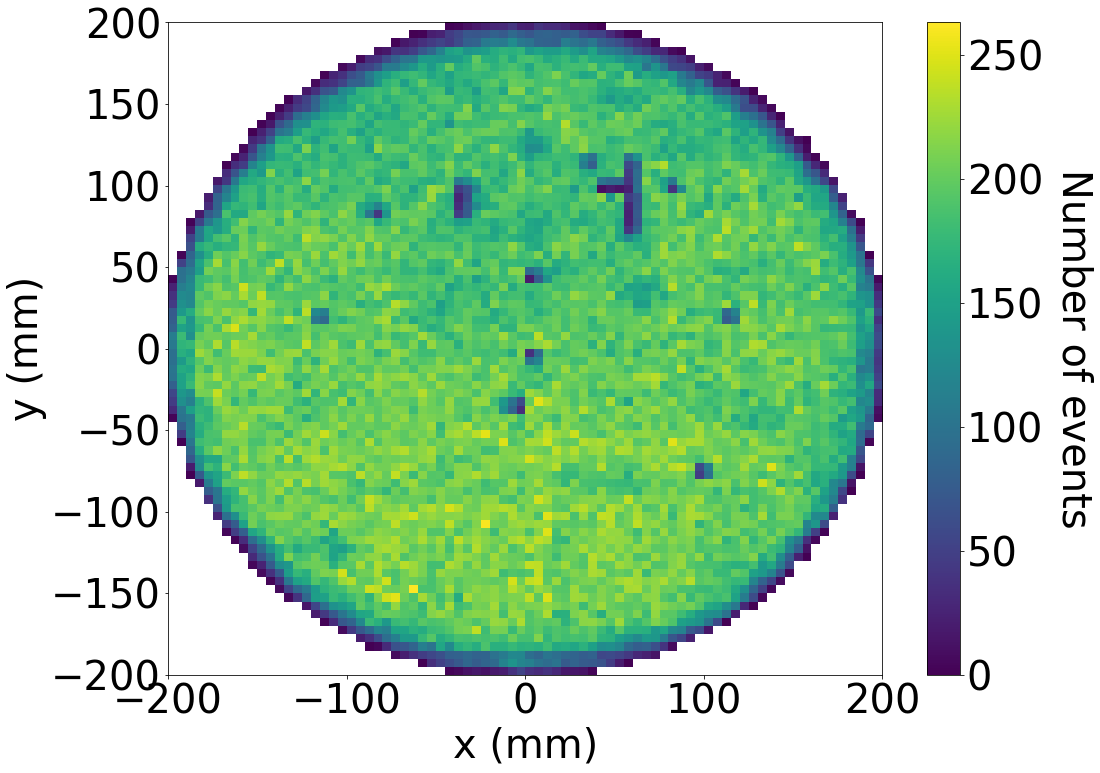

In [19]:
nxy, *_ = hist2d(X, Y, (XYbins, XYbins), cmin=1)
plt.colorbar().set_label("Number of events", rotation=-90, labelpad=50)
plt.clim(0, np.nanmax(nxy))

labels("x (mm)", "y (mm)")
save("XYHD3")

##### Energy resolution

In [20]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, bkg=fitf.gauss, n_sigma=3, n_it=10):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    if bkg is fitf.gauss:
        seed         = (      Npeak,     Epeak,  Speak, Npeak*2,   Epeak, Speak*50)
        lower_bounds = (          0,         0,      0,       0,       0,        0)
        upper_bounds = (10 * E.size, np.max(E), np.inf, +np.inf, +np.inf,  +np.inf)
    elif bkg is fitf.polynom:
        seed         = (      Npeak,     Epeak,  Speak,      -1,       1,       1)
        lower_bounds = (          0,         0,      0, -np.inf, -np.inf, -np.inf)
        upper_bounds = (10 * E.size, np.max(E), np.inf,       0, +np.inf, +np.inf)
    else:
        seed         = (      Npeak,     Epeak,  Speak)
        lower_bounds = (          0,         0,      0)
        upper_bounds = (10 * E.size, np.max(E), np.inf)
        bkg          = lambda *args: 0

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])

    for i in itertools.count():
        try:
            seed = np.random.normal(seed, np.abs(seed) * 0.2)
            seed = np.clip(seed, lower_bounds, upper_bounds)
            fit_range = (Epeak - n_sigma * Speak,
                         Epeak + n_sigma * Speak)
            f    = fitf.fit(fun, x, y, seed,
                            fit_range = fit_range,
                            sigma     = yu,
                            bounds    = (lower_bounds, upper_bounds),
                            maxfev    = 10000)

            assert not np.any(np.isclose(f.values, seed)), f.values
            assert f.chi2 < 10

            R   = resolution(f.values, f.errors, 41.5)
            sel = coref.in_range(x, *fit_range)
            ry  = (f.fn(x) - y) / yu
            return reso_fit_data(xy_data(x, y, xu, yu),
                                 xy_data(x[sel], ry[sel], xu, yu[sel]),
                                 f, R)
        except (AssertionError, RuntimeError) as e:
            print(f"Failed {i}")
            if i < n_it: continue
            raise e

Failed 0
Resolution at 41.5 keV: 4.553 +- 0.010
Resolution at 2458 keV: 0.5916 +- 0.0014
Chi2                  : 2.52716229939


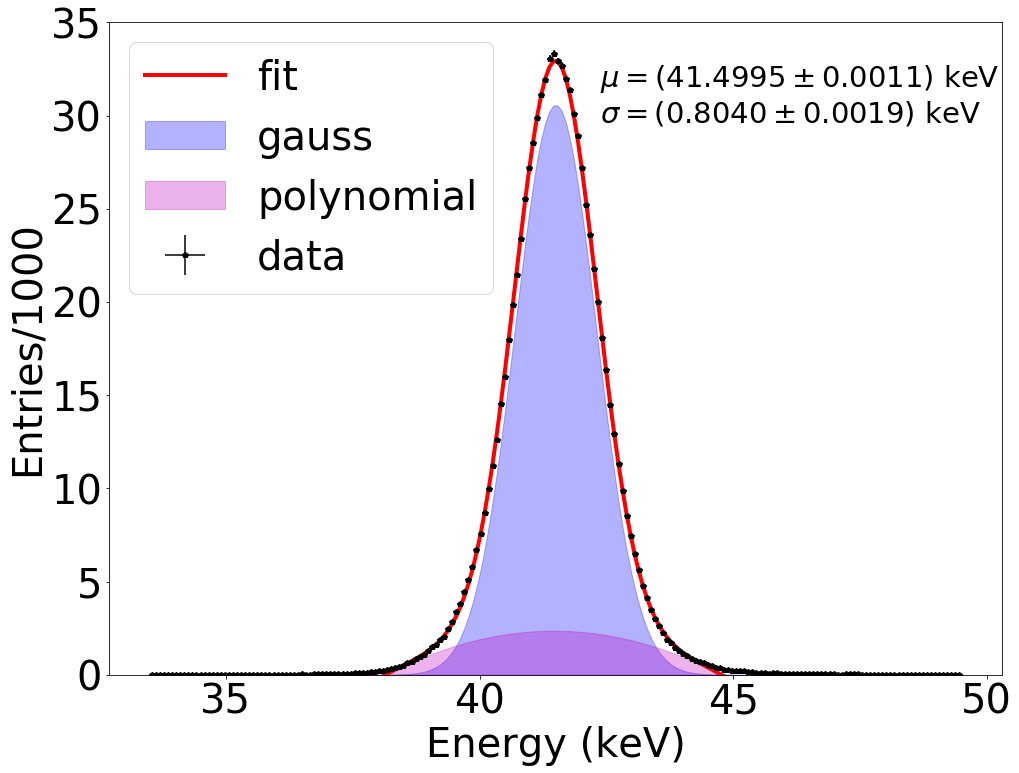

In [63]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k", label="data")
plt.plot        (x, data.f.fn   (x)                   , lw=global_linewidth, color=global_linecolor   , label="fit")
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0], label="gauss")
plt.fill_between(x, bkg       (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1], label="polynomial")
plt.text(0.55, 0.85,
         "$\mu = ({})$ keV\n$\sigma = ({})$ keV".format(valuepm(data.f.values[1], data.f.errors[1]),
                                                        valuepm(data.f.values[2], data.f.errors[2])),
         transform=plt.gca().transAxes,
         fontsize = label_font_size - 1)


plt.ylim(0, 35e3)
plt.legend(loc="upper left")

plt.yticks(plt.yticks()[0], list(map(lambda x: str(int(x/1000)), plt.yticks()[0])))
labels("Energy (keV)", "Entries/1000", "Energy spectrum")
save(f"Resolution_{run_number}_full")

##### Energy resolution best case

In [64]:
Z_fiducial = 150
R_fiducial = 150

Resolution at 41.5 keV: 3.804 +- 0.013
Resolution at 2458 keV: 0.4943 +- 0.0017
Chi2                  : 1.86649493377


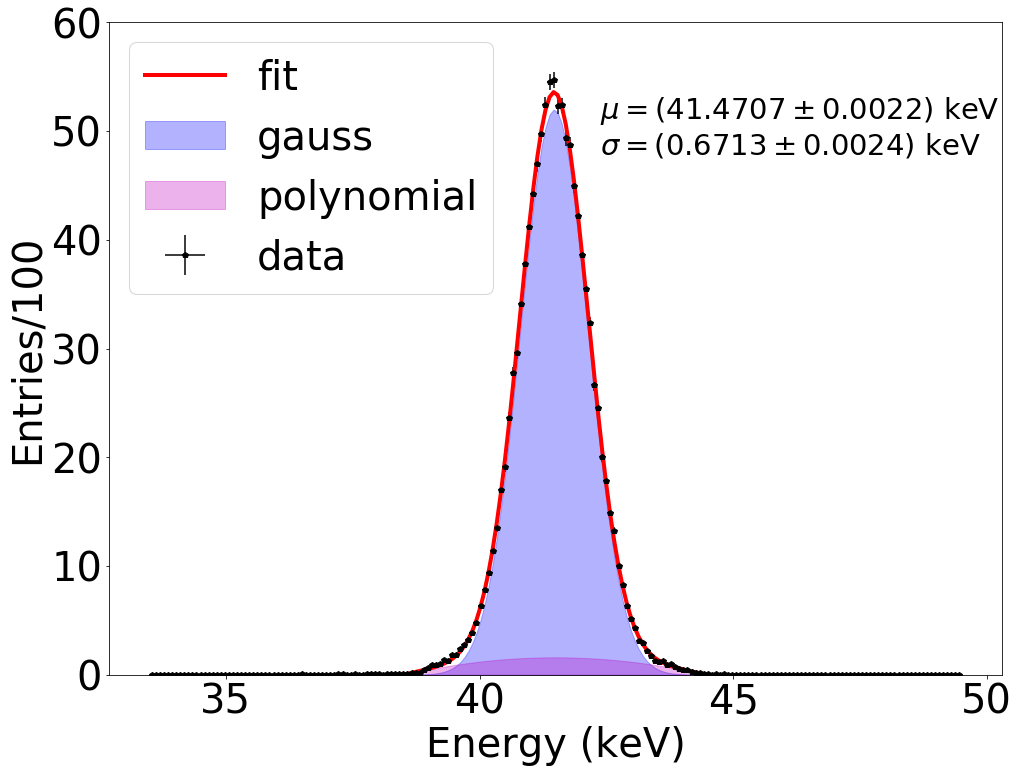

In [66]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 0, Z_fiducial)
bkg   = fitf.polynom
data  = measure_resolution(E[sel_r & sel_z], bkg=bkg, n_sigma=4)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k", label="data")
plt.plot        (x, data.f.fn (x)                     , lw=global_linewidth, color=global_linecolor   , label="fit")
plt.fill_between(x, fitf.gauss(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0], label="gauss")
plt.fill_between(x,bkg        (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1], label="polynomial")
plt.text(0.55, 0.8,
         "$\mu = ({})$ keV\n$\sigma = ({})$ keV".format(valuepm(data.f.values[1], data.f.errors[1]),
                                                        valuepm(data.f.values[2], data.f.errors[2])),
         transform=plt.gca().transAxes,
         fontsize = label_font_size - 1)

plt.ylim(0, 6000)
plt.yticks(plt.yticks()[0], list(map(lambda x: str(int(x/100)), plt.yticks()[0])))

plt.legend(loc="upper left")

labels("Energy (keV)", "Entries/100", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save(f"Resolution_{run_number}_fid")

##### Energy resolution dependence

In [34]:
Z_fiducial = 200
R_fiducial = 100

Failed 0
R in [0.0, 12.5) mm
| Resolution at 2458 keV: 0.4661 +- 0.0063
| Chi2                  : 0.840229985225
Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
R in [12.5, 25.0) mm
| Resolution at 2458 keV: 0.4647 +- 0.0036
| Chi2                  : 1.46311107459
Failed 0
R in [25.0, 37.5) mm
| Resolution at 2458 keV: 0.4624 +- 0.0028
| Chi2                  : 1.49893987601
R in [37.5, 50.0) mm
| Resolution at 2458 keV: 0.4637 +- 0.0023
| Chi2                  : 1.06604214992
R in [50.0, 62.5) mm
| Resolution at 2458 keV: 0.4638 +- 0.0021
| Chi2                  : 0.766588400096
R in [62.5, 75.0) mm
| Resolution at 2458 keV: 0.4667 +- 0.0019
| Chi2                  : 0.912362979085
R in [75.0, 87.5) mm
| Resolution at 2458 keV: 0.4695 +- 0.0017
| Chi2                  : 0.878754140211
R in [87.5, 100.0) mm
| Resolution at 2458 keV: 0.4766 +- 0.0016
| Chi2                  : 0.919697078772
R in [100.0, 112.5) mm
| Resolution at 2458 keV: 0.4741 +- 0.0015
| Chi2          

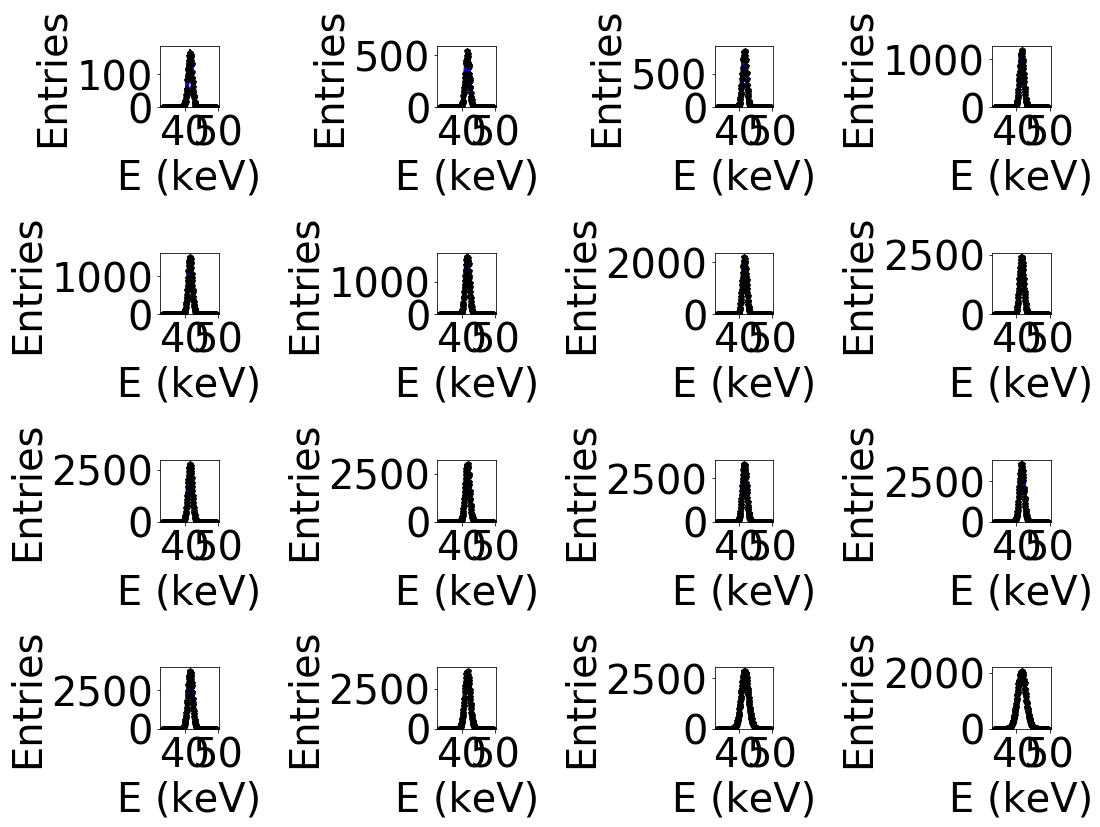

In [35]:
rbins = np.linspace(*Rrange, 17)
nbins = len(rbins) - 1
r     = shift_to_bin_centers(rbins)
dr    = 0.5 * np.diff       (rbins)

valid_mc         = np.zeros(nbins, dtype=bool     )
Chi2_mc          = np.zeros(nbins, dtype=np.double)
Resolution_mc    = np.zeros(nbins, dtype=np.double)
Resolutionu_mc   = np.zeros(nbins, dtype=np.double)
ResolutionBB_mc  = np.zeros(nbins, dtype=np.double)
ResolutionBBu_mc = np.zeros(nbins, dtype=np.double)

sel_z = coref.in_range(Z_mc, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        rmin, rmax = rbins[i:i+2]
        sel_r = coref.in_range(R_mc, rmin, rmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E_mc[sel], bkg=None, n_it=50)

        print(f"R in [{rmin:.1f}, {rmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution_mc  [i], Resolutionu_mc  [i] = data.R[0]
        ResolutionBB_mc[i], ResolutionBBu_mc[i] = data.R[1]
        Chi2_mc        [i]                      = data.f.chi2
        valid_mc       [i]                      = True
    except:
        pass

plt.tight_layout()
save("ResolutionRslices")

Failed 0
R in [0.0, 12.5) mm
| Resolution at 2458 keV: 0.514 +- 0.031
| Chi2                  : 1.01870066397
Failed 0
Failed 1
Failed 2
R in [12.5, 25.0) mm
| Resolution at 2458 keV: 0.521 +- 0.021
| Chi2                  : 0.819229230966
R in [25.0, 37.5) mm
| Resolution at 2458 keV: 0.511 +- 0.014
| Chi2                  : 0.853627927712
Failed 0
Failed 1
Failed 2
Failed 3
R in [37.5, 50.0) mm
| Resolution at 2458 keV: 0.486 +- 0.013
| Chi2                  : 0.696038735303
Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
Failed 7
Failed 8
Failed 9
Failed 10
Failed 11
Failed 12
Failed 13
Failed 14
Failed 15
Failed 16
Failed 17
Failed 18
Failed 19
Failed 20
Failed 21
Failed 22
Failed 23
Failed 24
Failed 25
Failed 26
Failed 27
Failed 28
Failed 29
Failed 30
Failed 31
Failed 32
Failed 33
Failed 34
Failed 35
Failed 36
Failed 37
Failed 38
Failed 39
Failed 40
Failed 41
Failed 42
Failed 43
Failed 44
Failed 45
Failed 46
Failed 47
Failed 48
R in [50.0, 62.5) mm
| Resolution at 2

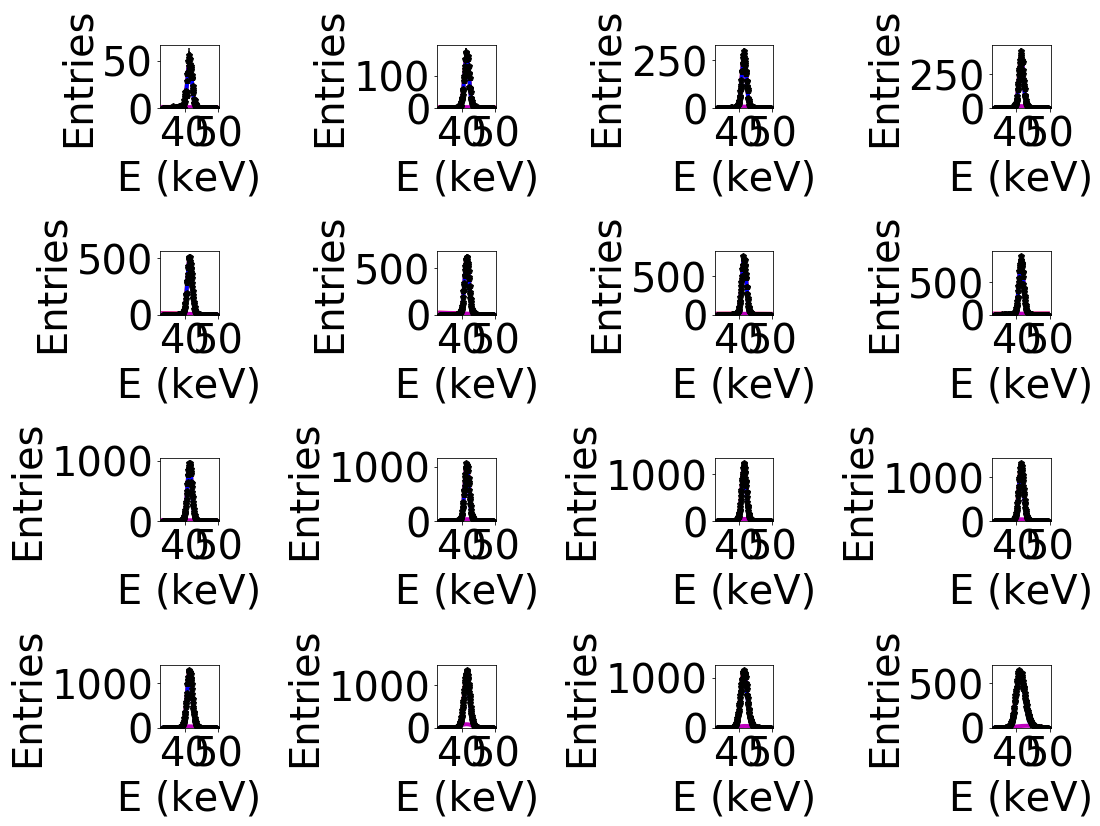

In [42]:
rbins = np.linspace(*Rrange, 17)
nbins = len(rbins) - 1
r     = shift_to_bin_centers(rbins)
dr    = 0.5 * np.diff       (rbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        rmin, rmax = rbins[i:i+2]
        sel_r = coref.in_range(R, rmin, rmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom, n_it=50)

        print(f"R in [{rmin:.1f}, {rmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionRslices")

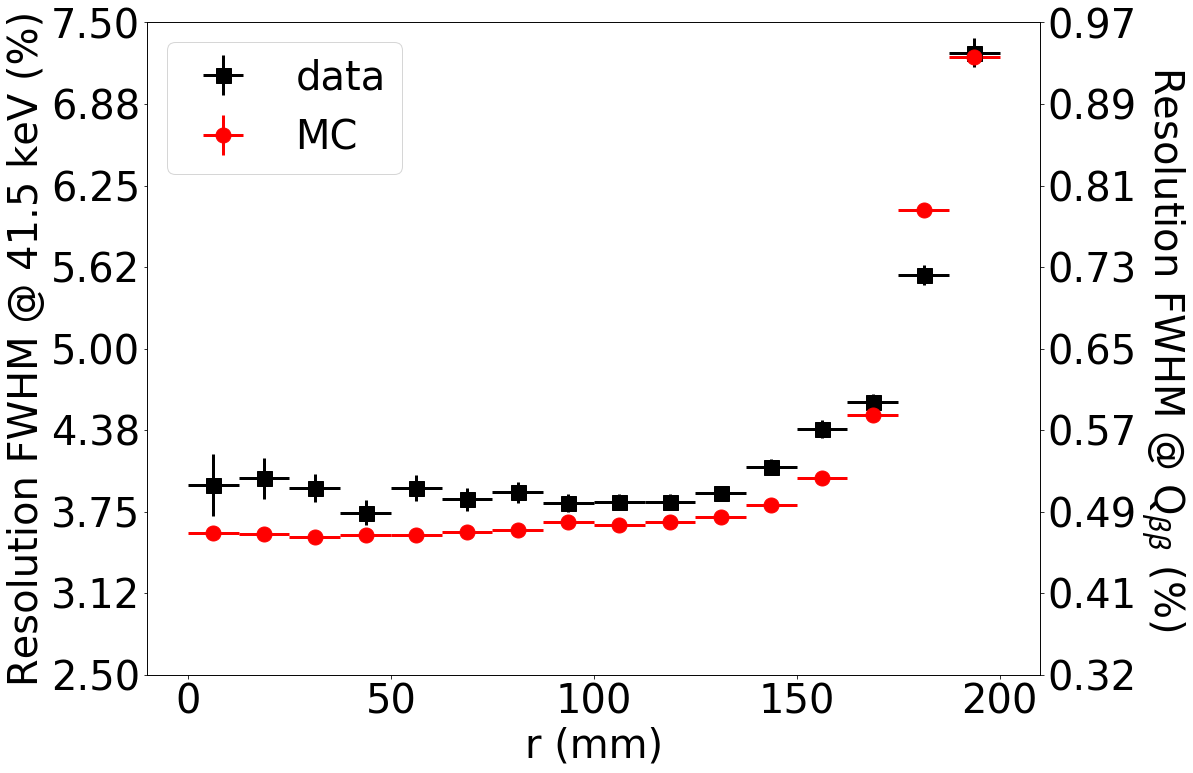

In [44]:
plt.errorbar(r[valid   ], Resolution   [valid   ], Resolutionu   [valid   ], dr[valid   ], "ks", lw=3, ms=15, label="data")
plt.errorbar(r[valid_mc], Resolution_mc[valid_mc], Resolutionu_mc[valid_mc], dr[valid_mc], "ro", lw=3, ms=15, label="MC")
labels("r (mm)", "Resolution FWHM @ 41.5 keV (%)")

plt.legend()

ylims  = 2.5, 7.5
yticks = np.linspace(*ylims, 9)
ystr   = ["{:.2f}".format(i) for i in yticks]
plt.ylim(*ylims)
plt.yticks(yticks, ystr)

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in ylims]
new_ticks = yticks * (41.5 / 2458)**0.5
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution FWHM @ Q$_{\\beta\\beta}$ (%)", rotation=-90, labelpad=50);

save(f"Resolution_vs_R_{run_number}")

In [55]:
Zrange = 100, 520

Z in [100.0, 135.0) mm
| Resolution at 2458 keV: 0.4706 +- 0.0018
| Chi2                  : 1.0766714726
Z in [135.0, 170.0) mm
| Resolution at 2458 keV: 0.4847 +- 0.0017
| Chi2                  : 0.781836794527
Z in [170.0, 205.0) mm
| Resolution at 2458 keV: 0.4962 +- 0.0017
| Chi2                  : 1.01669303376
Z in [205.0, 240.0) mm
| Resolution at 2458 keV: 0.5094 +- 0.0016
| Chi2                  : 0.793272346283
Z in [240.0, 275.0) mm
| Resolution at 2458 keV: 0.5269 +- 0.0017
| Chi2                  : 0.90805798246
Z in [275.0, 310.0) mm
| Resolution at 2458 keV: 0.5384 +- 0.0017
| Chi2                  : 1.16017837396
Z in [310.0, 345.0) mm
| Resolution at 2458 keV: 0.5505 +- 0.0017
| Chi2                  : 1.43679936299
Z in [345.0, 380.0) mm
| Resolution at 2458 keV: 0.5667 +- 0.0017
| Chi2                  : 1.12081300527
Failed 0
Failed 1
Z in [380.0, 415.0) mm
| Resolution at 2458 keV: 0.5776 +- 0.0017
| Chi2                  : 0.915378060499
Failed 0
Z in [415.0, 450.

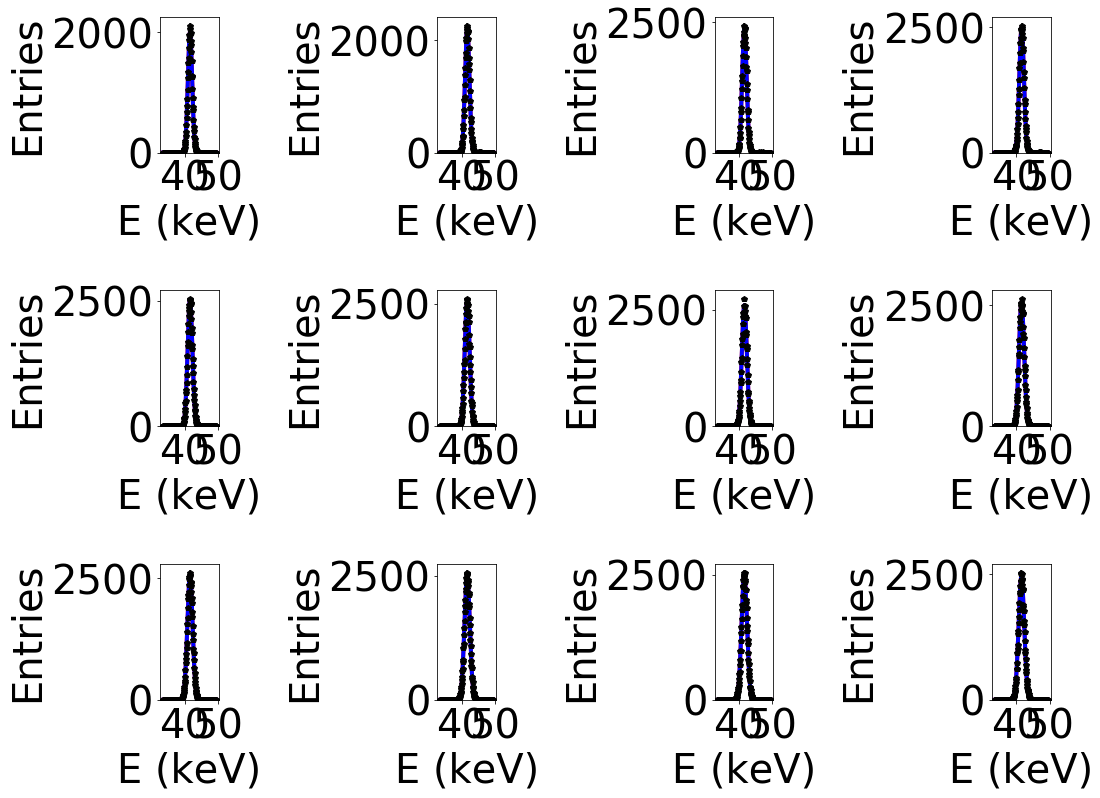

In [56]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid_mc         = np.zeros(nbins, dtype=bool     )
Chi2_mc          = np.zeros(nbins, dtype=np.double)
Resolution_mc    = np.zeros(nbins, dtype=np.double)
Resolutionu_mc   = np.zeros(nbins, dtype=np.double)
ResolutionBB_mc  = np.zeros(nbins, dtype=np.double)
ResolutionBBu_mc = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R_mc, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z_mc, zmin, zmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E_mc[sel], bkg=None, n_it=50)

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution_mc  [i], Resolutionu_mc  [i] = data.R[0]
        ResolutionBB_mc[i], ResolutionBBu_mc[i] = data.R[1]
        Chi2_mc        [i]                      = data.f.chi2
        valid_mc       [i]                      = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
Failed 7
Failed 8
Failed 9
Failed 10
Failed 11
Failed 12
Failed 13
Failed 14
Failed 15
Failed 16
Failed 17
Failed 18
Failed 19
Failed 20
Z in [100.0, 135.0) mm
| Resolution at 2458 keV: 0.5017 +- 0.0097
| Chi2                  : 1.17301054294
Failed 0
Z in [135.0, 170.0) mm
| Resolution at 2458 keV: 0.5116 +- 0.0091
| Chi2                  : 1.18703119477
Failed 0
Failed 1
Z in [170.0, 205.0) mm
| Resolution at 2458 keV: 0.5317 +- 0.0099
| Chi2                  : 1.20037737696
Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
Failed 7
Failed 8
Failed 9
Failed 10
Failed 11
Failed 12
Failed 13
Failed 14
Failed 15
Failed 16
Failed 17
Failed 18
Failed 19
Z in [205.0, 240.0) mm
| Resolution at 2458 keV: 0.5239 +- 0.0092
| Chi2                  : 1.05167834774
Failed 0
Failed 1
Failed 2
Failed 3
Failed 4
Failed 5
Failed 6
Failed 7
Failed 8
Failed 9
Failed 10
Failed 11
Failed 12
Failed 13
Failed 14
Failed 15
Failed 16

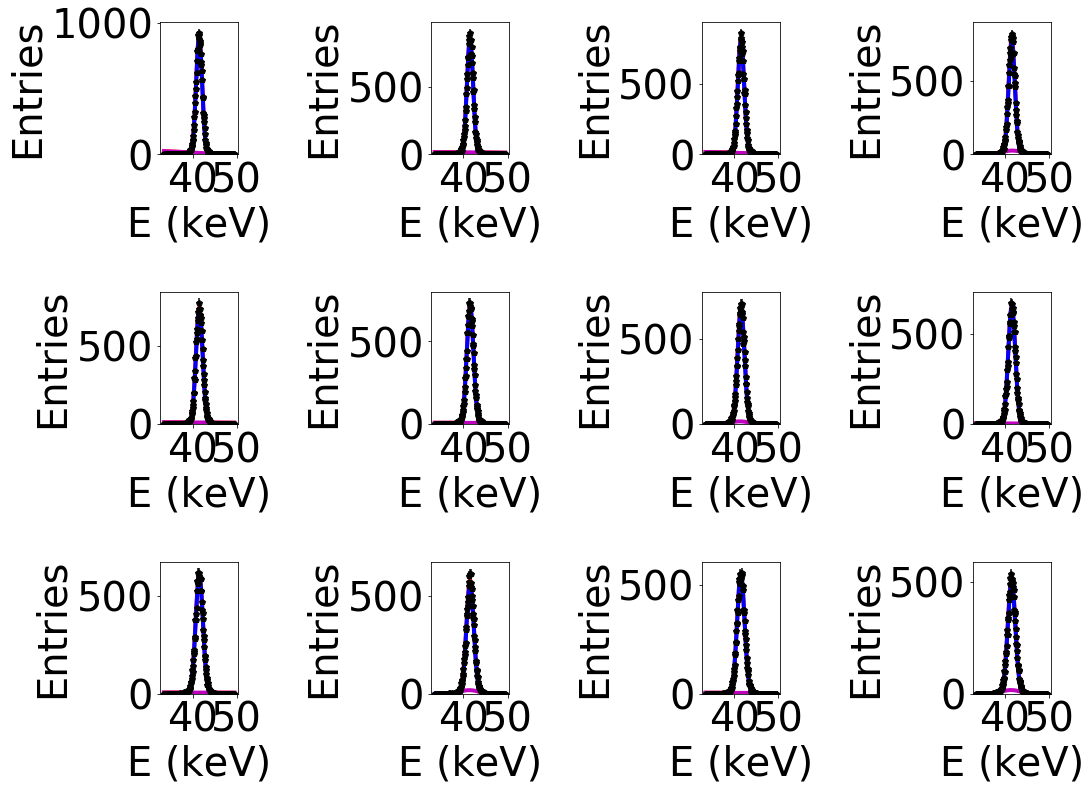

In [59]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z, zmin, zmax)
        sel   = sel_r & sel_z
        if np.count_nonzero(sel) < 100: continue

        data  = measure_resolution(E[sel], bkg=fitf.polynom, n_it=50)

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

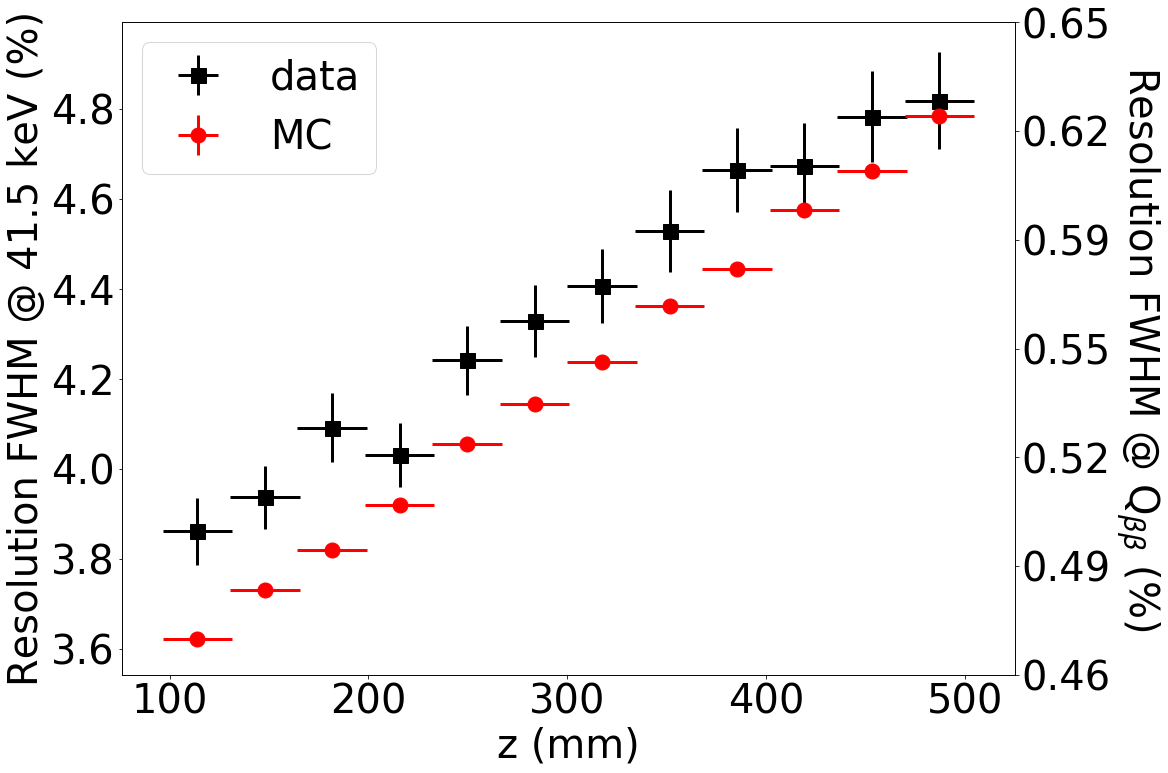

In [60]:
dv = 0.96973
plt.errorbar(z[valid   ] * dv, Resolution   [valid   ], Resolutionu   [valid   ], dz[valid   ], "ks", lw=3, ms=15, label="data")
plt.errorbar(z[valid_mc] * dv, Resolution_mc[valid_mc], Resolutionu_mc[valid_mc], dz[valid_mc], "ro", lw=3, ms=15, label="MC")

labels("z (mm)", "Resolution FWHM @ 41.5 keV (%)")

plt.legend()

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution FWHM @ Q$_{\\beta\\beta}$ (%)", rotation=-90, labelpad=50);

save(f"Resolution_vs_Z_{run_number}")